# Inferring from AssociateTracks414452.csv Data

In [1]:
# pip install matplotlib==3.3.4 -> Optional

In [2]:
import os
import sys
import glob
import h5py
import math
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras

In [3]:
import DGCNN_toolkit as nn
import analysis_toolkit as atk

In [4]:
df = pd.read_csv("AssociateTracks414452.csv")
df.head()

,iEvent,iHit,planeRec,wireRec,timeRec,HitRecTime0,HitRecTime1,Charge0,Charge1,Ampl0,Ampl1,x,y,z
0,0,0,1,274,-3.944810e-07,-3.937450e-07,-3.901820e-07,1.06798,0.515748,-100,-100,-4.89203,-24.8048,-68.341800
1,0,1,2,455,-4.065640e-07,-4.040480e-07,-4.040480e-07,1.36176,1.361760,-100,-100,-5.23458,-22.0926,0.158286
2,0,2,3,613,-3.314910e-07,-3.289760e-07,-3.289760e-07,4.85136,4.851360,-100,-100,17.01400,-13.7759,0.264502
3,0,3,3,659,-4.148150e-07,-4.135760e-07,-4.110250e-07,1.43517,0.970757,-100,-100,-8.14744,-21.1832,-42.452700
4,0,4,3,660,-4.209670e-07,-4.187150e-07,-4.181900e-07,1.52248,1.241020,-100,-100,-12.14240,-18.4606,-11.032600


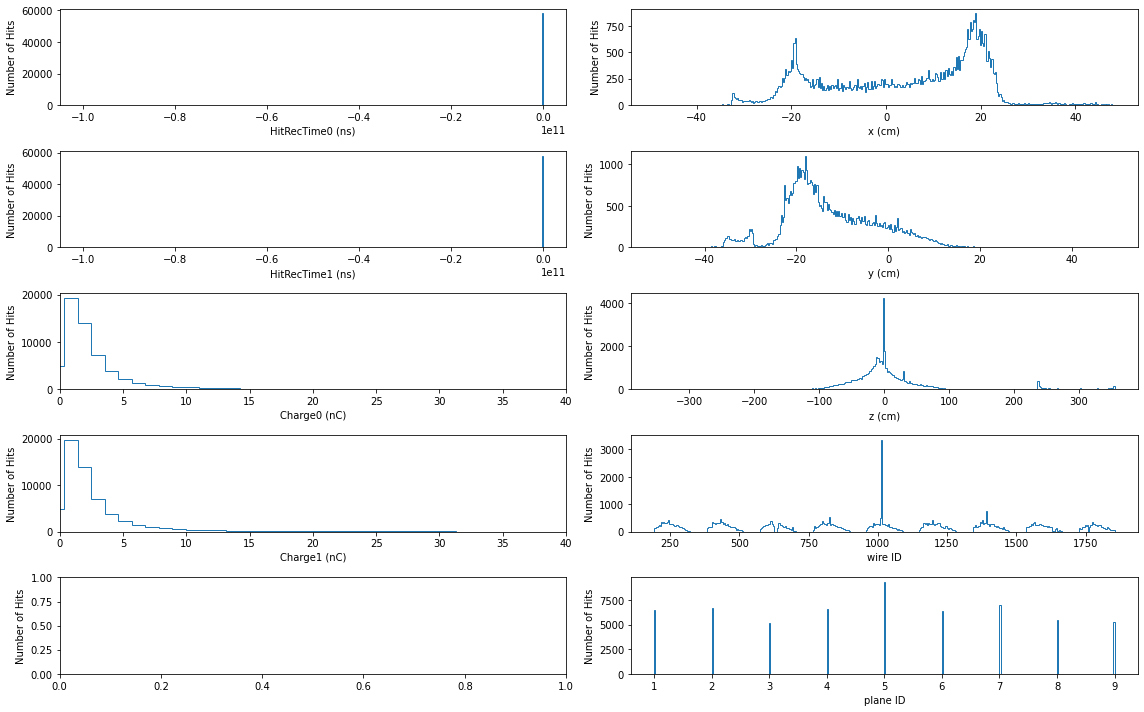

In [5]:
atk.sup_plot(df,400)

In [6]:
# Clearing Phase

clear_df = df[(df["Charge0"] != df["Charge1"]) &
                  (df.z > -100) & 
                  (df.z <  100) & 
                  (df.x > -30) & 
                  (df.x <  30) & 
                  (df.y > -30) & 
                  (df.y <  30) &
                  (df.timeRec >-600*1e-9) &
                  (df.timeRec <-200*1e-9) &
                  (df.HitRecTime0 >-1000*1e-9) &
                  (df.HitRecTime0 <0) &
                  (df.HitRecTime1 >-1000*1e-9) &
                  (df.HitRecTime1 <0)
                  ].dropna()

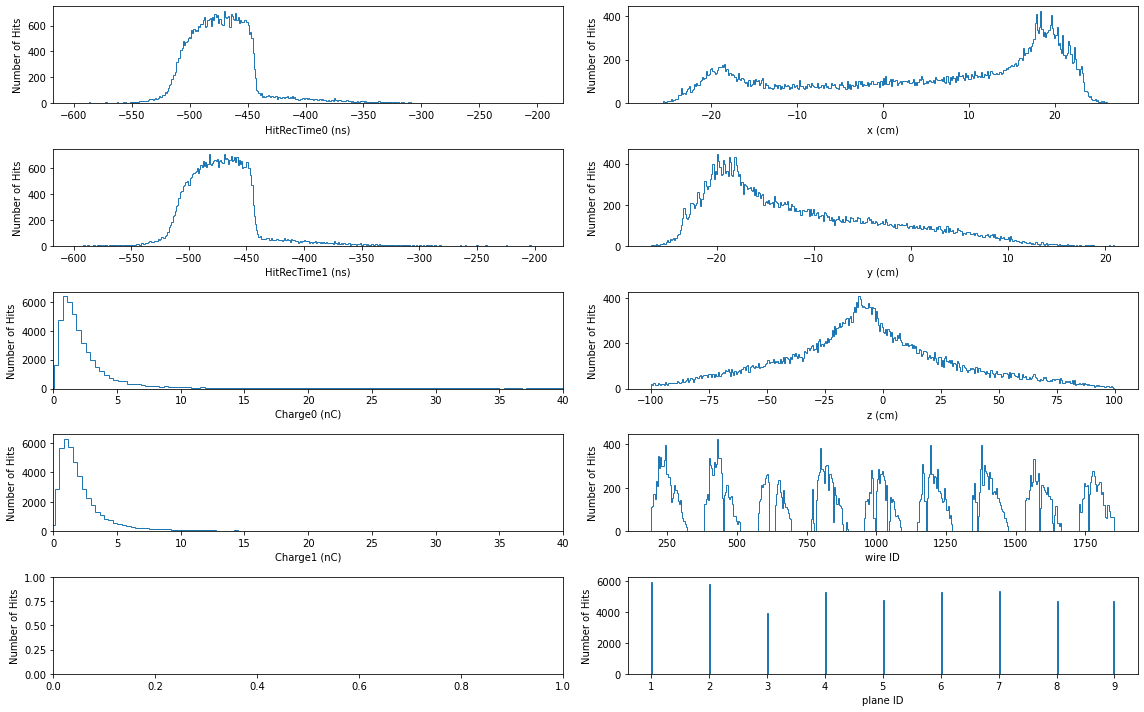

In [7]:
atk.sup_plot(clear_df, 400, savename="clear_df_all.png")

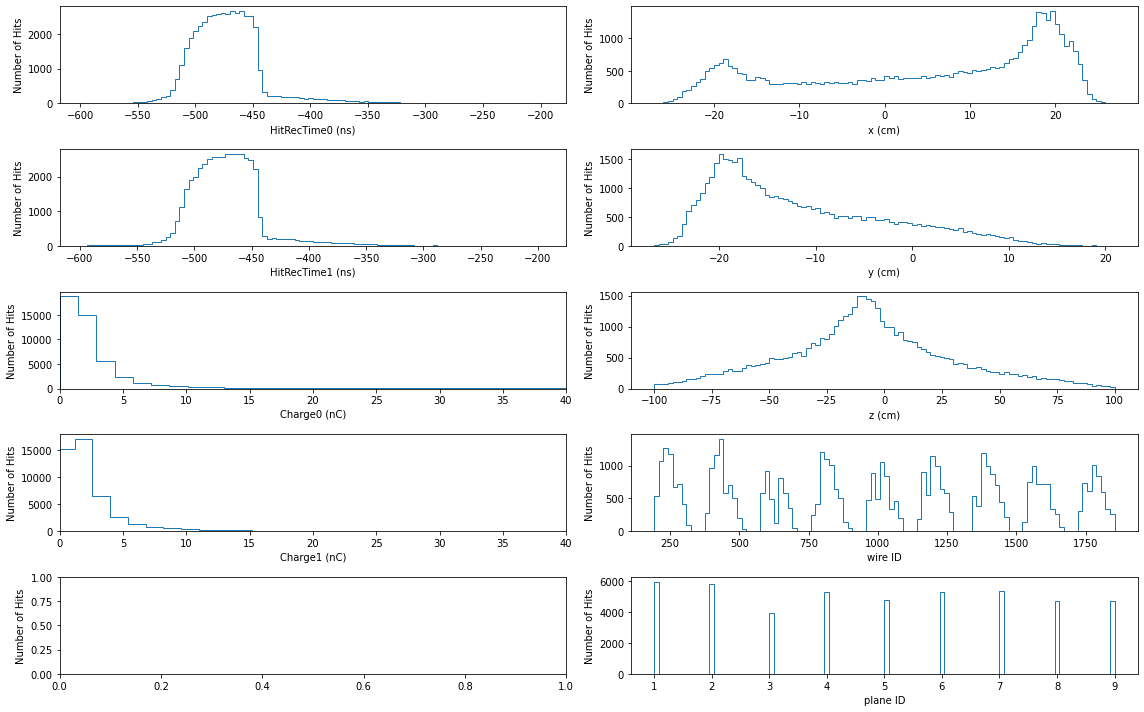

In [8]:
atk.sup_plot(clear_df, 100, savename="clear_df_all.png")

In [9]:
## Problem below.
# After some cuts we have non-subsequent hit indexing.
# Therefore, a reindexing of iHits is needed.
# Or just throw away randomly hits from events that have more than 432 hits.

In [10]:
#### This is a problem. The network was trained with 432 points.
# It cannot extrapolate automatically.
# We need to cut the events with more hits than 432.

(clear_df.shape[0] - clear_df[clear_df.iHit < 432].shape[0]) / (clear_df.shape[0])

0.0

In [11]:
# Okay we lost 0.0% of the data.

crop_df = clear_df[clear_df.iHit < 432]
crop_df = crop_df.reset_index(drop=True)
crop_df

,iEvent,iHit,planeRec,wireRec,timeRec,HitRecTime0,HitRecTime1,Charge0,Charge1,Ampl0,Ampl1,x,y,z
0,0,0,1,274,-3.944810e-07,-3.937450e-07,-3.901820e-07,1.067980,0.515748,-100,-100,-4.89203,-24.8048,-68.34180
1,0,3,3,659,-4.148150e-07,-4.135760e-07,-4.110250e-07,1.435170,0.970757,-100,-100,-8.14744,-21.1832,-42.45270
2,0,4,3,660,-4.209670e-07,-4.187150e-07,-4.181900e-07,1.522480,1.241020,-100,-100,-12.14240,-18.4606,-11.03260
3,0,5,4,819,-4.288450e-07,-4.267700e-07,-4.258950e-07,1.638570,1.475930,-100,-100,6.74216,-20.1475,-15.82110
4,0,6,4,820,-5.095660e-07,-5.071270e-07,-5.069790e-07,4.001080,4.054890,-100,-100,7.68226,-19.6260,-1.34661
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45782,3093,2,3,656,-4.488190e-07,-4.454320e-07,-4.471780e-07,1.152500,1.616040,-100,-100,-14.42050,-17.1712,30.56040
45783,3093,4,6,1244,-5.039820e-07,-5.009690e-07,-5.019740e-07,4.568240,5.726640,-100,-100,-14.28340,-14.1802,22.02150
45784,3093,5,7,1426,-4.586560e-07,-4.553610e-07,-4.569320e-07,2.251740,2.870170,-100,-100,-12.92460,-14.7115,23.19270
45785,3093,6,8,1628,-4.978420e-07,-4.947950e-07,-4.958720e-07,1.580360,1.600990,-100,-100,-13.69430,-12.9596,17.83370


In [12]:
# Max number of hits in an event before cropping

clear_df.iEvent.value_counts().max()

87

In [13]:
# Max number of hits in an event after cropping

crop_df.iEvent.value_counts().max()

87

In [14]:
# This knowledge comes from the training phase.
# In the future, we may also obtain these from the loaded model.

num_classes = 5
num_hits = 432

In [15]:
# The dataframe must be split into data and labels

data, label = nn.prepare_input(crop_df, "real", num_hits)

In [16]:
# This is only an inference session. Only test Dataset object is present.

test = nn.Dataset(data, label, num_classes)

In [17]:
input_shapes = {"points": (432,3),
                "features": (432,3),
                "mask": (432,1)}

model = nn.get_DGCNN(num_classes, input_shapes)

In [18]:
model.compile(loss='categorical_crossentropy',
              optimizer=keras.optimizers.Adam(learning_rate=nn.lr_schedule(0)),
              metrics=["accuracy"])
model.summary()

Model: "DGCNN_SG"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
mask (InputLayer)               [(None, 432, 1)]     0                                            
__________________________________________________________________________________________________
tf_op_layer_NotEqual (TensorFlo [(None, 432, 1)]     0           mask[0][0]                       
__________________________________________________________________________________________________
tf_op_layer_Cast (TensorFlowOpL [(None, 432, 1)]     0           tf_op_layer_NotEqual[0][0]       
__________________________________________________________________________________________________
tf_op_layer_Equal (TensorFlowOp [(None, 432, 1)]     0           tf_op_layer_Cast[0][0]           
___________________________________________________________________________________________

In [19]:
test.X["points"].shape

(2744, 432, 3)

In [20]:
model.load_weights("model_checkpoints/DGCNN_modelbest_wn_onnx.h5")

pred = model.predict(test.X)

In [21]:
# Reshape to get the proper format from the ONNX format

pred = pred.reshape(-1,num_hits,num_classes)

In [22]:
# Number of hits belonging to different tracks

np.unique(pred.reshape(-1,num_classes).argmax(-1),return_counts=True)

(array([0, 1, 2, 3, 4]), array([    447,   17612,   27584,     144, 1139621]))

In [23]:
# Mean, min, max ... number of hits in an event

clear_df.iEvent.value_counts().describe()

count    2744.000000
mean       16.686224
std        11.218618
min         1.000000
25%         9.000000
50%        14.000000
75%        21.000000
max        87.000000
Name: iEvent, dtype: float64

In [24]:
crop_df.iEvent.value_counts().describe()

count    2744.000000
mean       16.686224
std        11.218618
min         1.000000
25%         9.000000
50%        14.000000
75%        21.000000
max        87.000000
Name: iEvent, dtype: float64

In [25]:
testpred = atk.combine_testpred(test,pred)
testpred

,iEvent,iHit,x,y,z,track
0,0,0,-4.89203,-24.8048,-68.34180,1
1,0,1,-8.14744,-21.1832,-42.45270,2
2,0,2,-12.14240,-18.4606,-11.03260,2
3,0,3,6.74216,-20.1475,-15.82110,2
4,0,4,7.68226,-19.6260,-1.34661,2
...,...,...,...,...,...,...
1185403,2743,427,0.00000,0.0000,0.00000,4
1185404,2743,428,0.00000,0.0000,0.00000,4
1185405,2743,429,0.00000,0.0000,0.00000,4
1185406,2743,430,0.00000,0.0000,0.00000,4


Event id is  2009


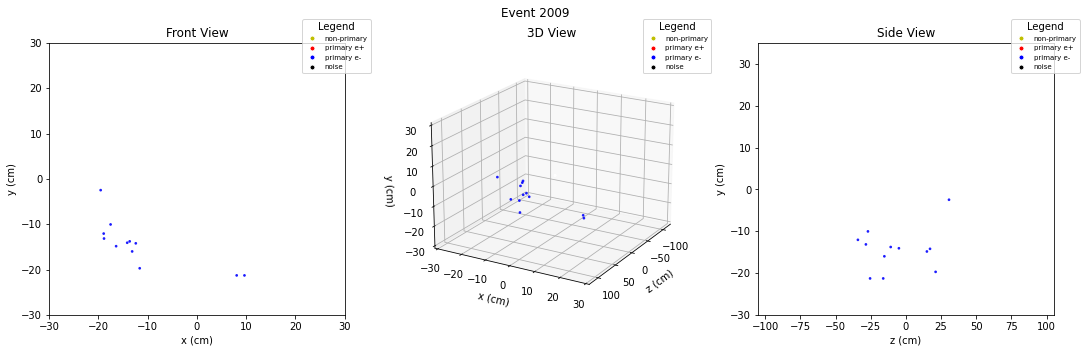

In [26]:
atk.EventSelector(testpred).plot(views="front 3D side")

In [27]:
# See the prediction contents

pred_contents = atk.get_event_contents(pred)

# Also reindex to get the same iEvent with the dataframe
pred_contents.index = crop_df.iEvent.unique()
pred_contents.index = pred_contents.index.rename("iEvent")
pred_contents

,e+,e-,sec,noise,tot
iEvent,,,,,
0,3.0,25.0,0.0,2.0,30.0
1,0.0,17.0,0.0,1.0,18.0
2,0.0,8.0,0.0,0.0,8.0
3,10.0,0.0,0.0,0.0,10.0
4,12.0,0.0,0.0,0.0,12.0
...,...,...,...,...,...
3088,8.0,16.0,0.0,1.0,25.0
3089,21.0,0.0,0.0,0.0,21.0
3090,0.0,20.0,0.0,0.0,20.0


In [28]:
# This was the acceptance condition for pair events.

pred_contents[(pred_contents["e+"] > 6) & (pred_contents["e-"] > 6)]

,e+,e-,sec,noise,tot
iEvent,,,,,
16,7.0,10.0,0.0,0.0,17.0
32,31.0,43.0,0.0,0.0,74.0
35,15.0,7.0,0.0,0.0,22.0
44,18.0,22.0,0.0,0.0,40.0
50,29.0,22.0,0.0,0.0,51.0
...,...,...,...,...,...
3068,8.0,37.0,0.0,0.0,45.0
3072,13.0,12.0,0.0,0.0,25.0
3076,18.0,7.0,0.0,0.0,25.0


Saving figure to colored_plots14.png  done.
Saving figure to colored_plots28.png  done.
Saving figure to colored_plots31.png  done.
Saving figure to colored_plots40.png  done.
Saving figure to colored_plots44.png  done.


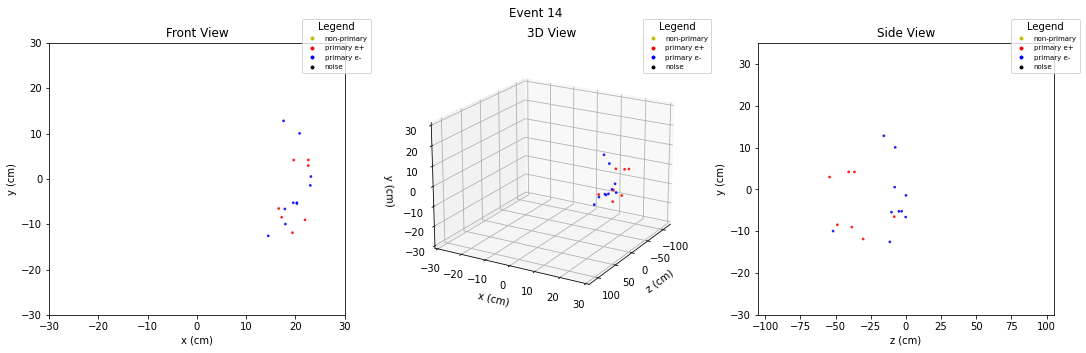

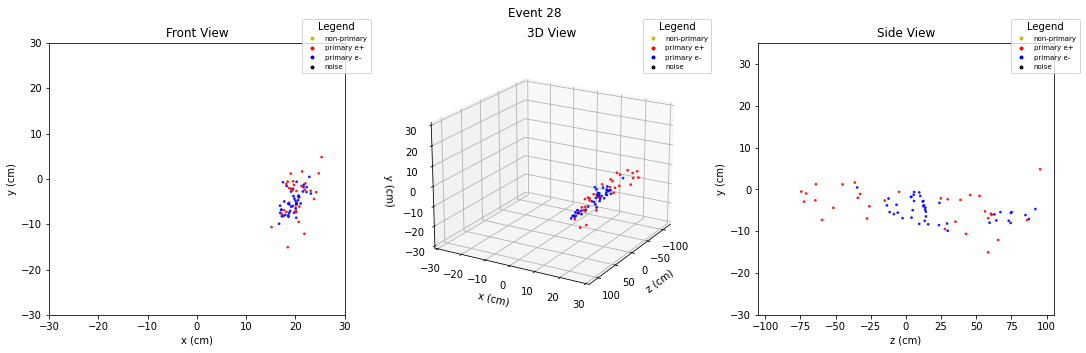

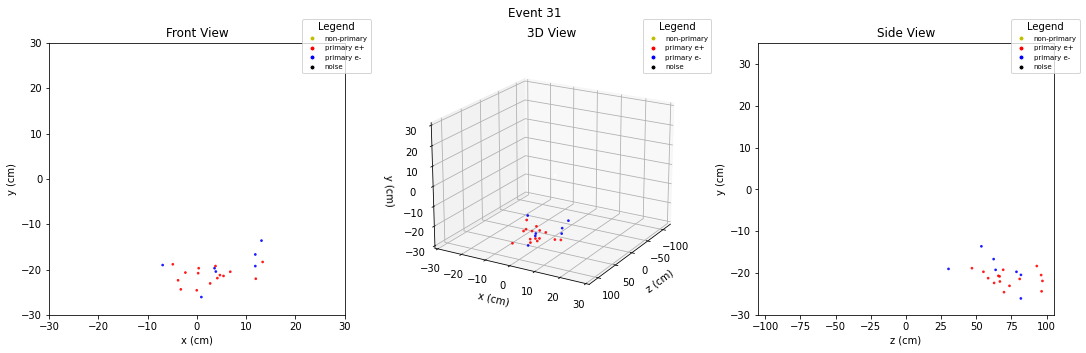

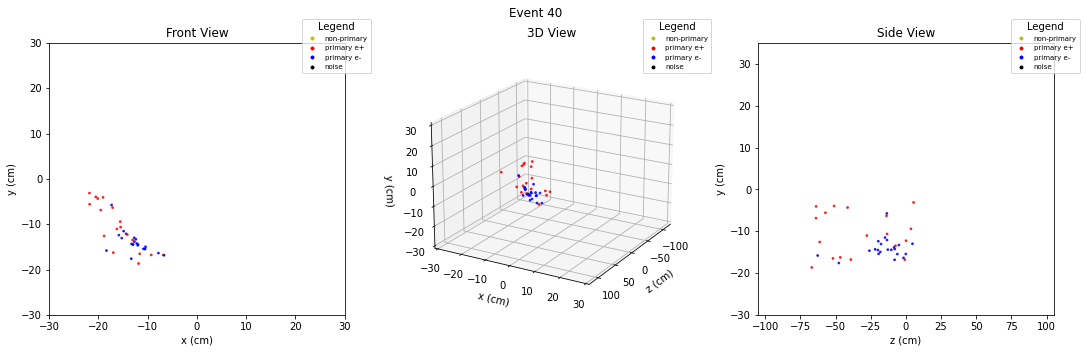

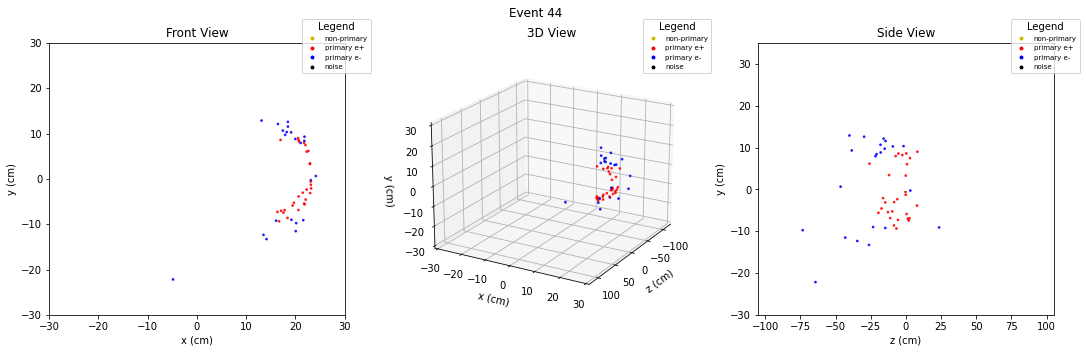

In [29]:
# Create single event objects, and plot them.

for i in [14,28,31,40,44]:
    atk.EventSelector(testpred, i).plot("front 3D side", save=True)

#### Note for myself:

Little info on copying dataframes: \
Deep copy is necessary if you want to modify existing features and indices.\
Shallow copy is required if you want to add new features and indices, \
but not to modify existing ones. \
If you just make modifications on the dataframe, existing one changes. \

In [30]:
# To get consequent numbering in iEvent column

crop_df2 = crop_df.copy(deep=True)
crop_df2.iEvent = np.unique(crop_df.iEvent.to_numpy(), return_inverse=True)[1]
crop_df2

,iEvent,iHit,planeRec,wireRec,timeRec,HitRecTime0,HitRecTime1,Charge0,Charge1,Ampl0,Ampl1,x,y,z
0,0,0,1,274,-3.944810e-07,-3.937450e-07,-3.901820e-07,1.067980,0.515748,-100,-100,-4.89203,-24.8048,-68.34180
1,0,3,3,659,-4.148150e-07,-4.135760e-07,-4.110250e-07,1.435170,0.970757,-100,-100,-8.14744,-21.1832,-42.45270
2,0,4,3,660,-4.209670e-07,-4.187150e-07,-4.181900e-07,1.522480,1.241020,-100,-100,-12.14240,-18.4606,-11.03260
3,0,5,4,819,-4.288450e-07,-4.267700e-07,-4.258950e-07,1.638570,1.475930,-100,-100,6.74216,-20.1475,-15.82110
4,0,6,4,820,-5.095660e-07,-5.071270e-07,-5.069790e-07,4.001080,4.054890,-100,-100,7.68226,-19.6260,-1.34661
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45782,2743,2,3,656,-4.488190e-07,-4.454320e-07,-4.471780e-07,1.152500,1.616040,-100,-100,-14.42050,-17.1712,30.56040
45783,2743,4,6,1244,-5.039820e-07,-5.009690e-07,-5.019740e-07,4.568240,5.726640,-100,-100,-14.28340,-14.1802,22.02150
45784,2743,5,7,1426,-4.586560e-07,-4.553610e-07,-4.569320e-07,2.251740,2.870170,-100,-100,-12.92460,-14.7115,23.19270
45785,2743,6,8,1628,-4.978420e-07,-4.947950e-07,-4.958720e-07,1.580360,1.600990,-100,-100,-13.69430,-12.9596,17.83370


In [31]:
dfpred = atk.combine_dfpred(crop_df2, pred)
dfpred

,iEvent,iHit,planeRec,wireRec,timeRec,HitRecTime0,HitRecTime1,Charge0,Charge1,Ampl0,Ampl1,x,y,z,track
0,0,0,1,274,-3.944810e-07,-3.937450e-07,-3.901820e-07,1.067980,0.515748,-100,-100,-4.89203,-24.8048,-68.34180,1
1,0,3,3,659,-4.148150e-07,-4.135760e-07,-4.110250e-07,1.435170,0.970757,-100,-100,-8.14744,-21.1832,-42.45270,2
2,0,4,3,660,-4.209670e-07,-4.187150e-07,-4.181900e-07,1.522480,1.241020,-100,-100,-12.14240,-18.4606,-11.03260,2
3,0,5,4,819,-4.288450e-07,-4.267700e-07,-4.258950e-07,1.638570,1.475930,-100,-100,6.74216,-20.1475,-15.82110,2
4,0,6,4,820,-5.095660e-07,-5.071270e-07,-5.069790e-07,4.001080,4.054890,-100,-100,7.68226,-19.6260,-1.34661,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45782,2743,2,3,656,-4.488190e-07,-4.454320e-07,-4.471780e-07,1.152500,1.616040,-100,-100,-14.42050,-17.1712,30.56040,2
45783,2743,4,6,1244,-5.039820e-07,-5.009690e-07,-5.019740e-07,4.568240,5.726640,-100,-100,-14.28340,-14.1802,22.02150,2
45784,2743,5,7,1426,-4.586560e-07,-4.553610e-07,-4.569320e-07,2.251740,2.870170,-100,-100,-12.92460,-14.7115,23.19270,2
45785,2743,6,8,1628,-4.978420e-07,-4.947950e-07,-4.958720e-07,1.580360,1.600990,-100,-100,-13.69430,-12.9596,17.83370,2


In [32]:
# Another way to combine dataframe and the event.
# Useful for displaying some histograms.
# Some functionalities are only available for inference.

dfpred = atk.combine_dfpred(crop_df, pred)

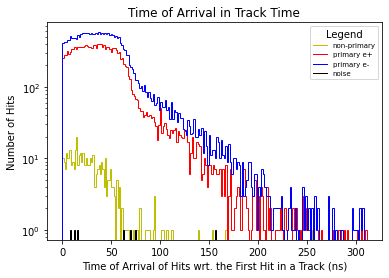

In [33]:
atk.draw_histogram(
    dfpred,
    np.linspace(0,100,100),
    "time of arrival - track time")

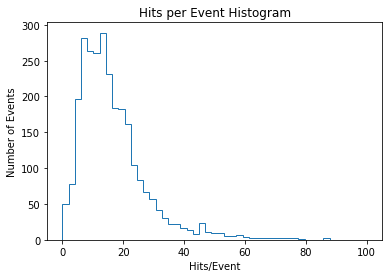

In [34]:
atk.draw_histogram(crop_df, np.linspace(0,100,50), "hits per event", histtype="step")

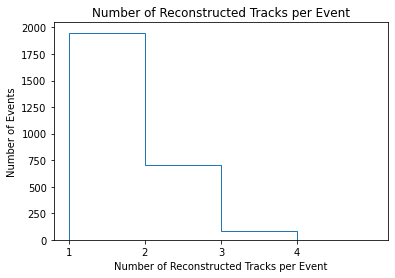

In [35]:
atk.draw_histogram(
    dfpred,
    None,
    "reconstructed tracks per event")

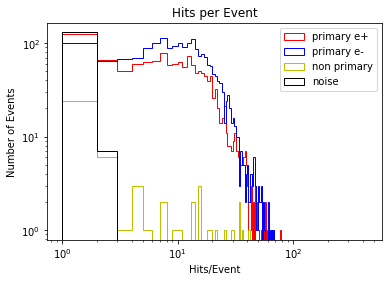

In [36]:
atk.draw_histogram(
    dfpred,
    None,
    "reconstructed hits per event")

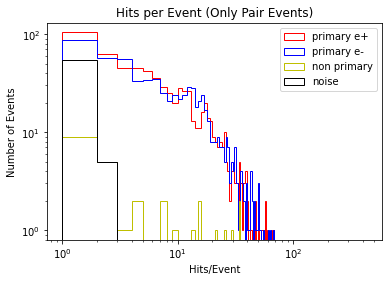

In [37]:
atk.draw_histogram(
    dfpred,
    None,
    "reconstructed hits per event (pair)")

In [38]:
# Number of hits for all tracks in all events

dfpred.groupby("iEvent").track.value_counts()

iEvent  track
0       2        25
        1         3
        3         2
1       2        17
        3         1
                 ..
3088    3         1
3089    1        21
3090    2        20
3091    2        18
3093    2         6
Name: track, Length: 3625, dtype: int64

In [39]:
dfpred.groupby("iEvent").track.value_counts().describe()

count    3625.000000
mean       12.630897
std         9.951596
min         1.000000
25%         5.000000
50%        11.000000
75%        17.000000
max        77.000000
Name: track, dtype: float64

In [40]:
pred_contents = pred_contents.groupby("tot").mean().reset_index()
pred_contents

,tot,e+,e-,sec,noise
0,1.0,0.540541,0.243243,0.216216,0.0
1,2.0,0.769231,1.076923,0.153846,0.0
2,3.0,0.952381,2.000000,0.047619,0.0
3,4.0,1.210526,2.754386,0.035088,0.0
4,5.0,1.522727,3.477273,0.000000,0.0
...,...,...,...,...,...
70,74.0,24.333333,49.666667,0.000000,0.0
71,76.0,24.500000,37.000000,14.500000,0.0
72,78.0,77.000000,0.000000,1.000000,0.0
73,86.0,35.000000,51.000000,0.000000,0.0


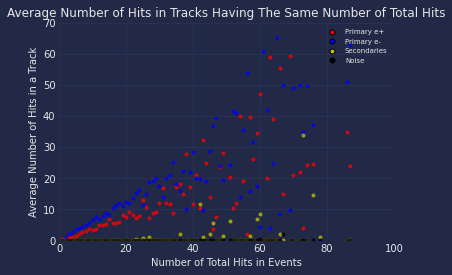

In [41]:
# Plot to see the distribution of number of hits in all tracks
# with respect to the change in the total number of hits.

plt.style.use("seaborn-dark")
for param in ['figure.facecolor', 'axes.facecolor', 'savefig.facecolor']:
    plt.rcParams[param] = '#212946'  # bluish dark grey
for param in ['text.color', 'axes.labelcolor', 'xtick.color', 'ytick.color']:
    plt.rcParams[param] = '0.9'  # very light grey
# plt.grid(color='#2A3459')  # bluish dark grey, but slightly lighter than background
from matplotlib.lines import Line2D
leg_handles = [Line2D([0], [0], marker='o', color="None", label='Primary e+',
                   markerfacecolor='r', markersize=5),
               Line2D([0], [0], marker='o', color="None", label='Primary e-',
                   markerfacecolor='b', markersize=5),
               Line2D([0], [0], marker='o', color="None", label='Secondaries',
                   markerfacecolor='y', markersize=5),
               Line2D([0], [0], marker='o', color="None", label='Noise',
                   markerfacecolor='k', markersize=5)
               ]

plt.plot(pred_contents.tot, pred_contents["e+"], "r.", alpha=0.7)
plt.plot(pred_contents.tot, pred_contents["e-"], "b.", alpha=0.7)
plt.plot(pred_contents.tot, pred_contents["sec"], "y.", alpha=0.7)
plt.plot(pred_contents.tot, pred_contents["noise"], "k.", alpha=0.7)
plt.grid(color='#2A3459')
plt.xlim(0,100)
plt.ylim(0,70)
plt.title("Average Number of Hits in Tracks Having The Same Number of Total Hits")
plt.xlabel("Number of Total Hits in Events")
plt.ylabel("Average Number of Hits in a Track")
plt.legend(handles=leg_handles, loc="upper right", fontsize=7)
# plt.title("Mean of Non-Primary Hits per Event When Primary Pairs are in Acceptance")
# plt.xlabel("Hits per Event")
# plt.ylabel("Average Noise Hits per Event")
plt.savefig("plots/mean_tracks_all.png", dpi=300, bbox_inches='tight')

In [ ]:
# To revert the seaborn plot styling:
# plt.style.use("default")
